<a href="https://colab.research.google.com/github/salifsw770/prj_merge/blob/main/Final_ML_wel_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("studymart/welfake-dataset-for-fake-news")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/studymart/welfake-dataset-for-fake-news/versions/1


In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU available: True
Device name: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1: Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve,  classification_report
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
import string
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install scikit-learn==1.2.2


# Step 2: Load Dataset

In [ ]:
data = pd.read_csv(path + '/WELFake_Dataset.csv')

In [ ]:
data.shape

(72134, 4)

In [ ]:
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
data.tail()

,Unnamed: 0,title,text,label
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0
72133,72133,Goldman Sachs Endorses Hillary Clinton For Pre...,Goldman Sachs Endorses Hillary Clinton For Pre...,1


In [ ]:
data['text'][0] #label 1, Fake News

'No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to be referred to

In [ ]:
data['text'][72129] #label 0, Real News

'WASHINGTON (Reuters) - Hackers believed to be working for the Russian government broke into the Democratic National Committee’s computer network, spied on internal communications and accessed research on presumptive Republican presidential nominee Donald Trump, the committee and security experts said on Tuesday. Two separate groups entered the DNC’s system, and one read email and chat communications for nearly a year before being detected, according to the committee and CrowdStrike, the cyber firm that helped clean up the breach. Russian spies also targeted the networks of Trump and Democratic presidential candidate Hillary Clinton, as well as the computers of some Republican political action committees, the Washington Post quoted U.S. officials as saying, although details were not available. A Clinton campaign official said there was no evidence the campaign’s information systems had been hacked. A Russian government spokesman denied involvement in the breach. “I completely rule out 

In [ ]:
data.drop('Unnamed: 0', axis=1, inplace=True)

# Step 3: Handle null values and separate features from labels

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
data.isnull().sum()

,0
title,558
text,39
label,0


In [ ]:
data['text'][4240]

'WASHINGTON (Reuters) - People would be able to bring legal, concealed guns into any U.S. state under legislation the House of Representatives approved on Wednesday that would also bolster the national background check system and require a study of the “bump stocks” used in October’s Las Vegas mass shooting. The country’s long-standing fight over gun ownership has grown more heated since a single person killed 58 people and injured more than 500 at a music festival in Las Vegas, Nevada, the deadliest mass shooting carried out by an individual in U.S. history. Stephen Paddock boosted his firearms with bump stocks to shoot thousands of bullets over 10 minutes. On a vote of 231 to 198, the Republican-led House approved the Concealed Carry Reciprocity Act, which would require states to recognize each others’ permits for carrying hidden and loaded firearms while in public. States’ requirements on concealed guns vary widely. Some states deny permits to people who have committed domestic viol

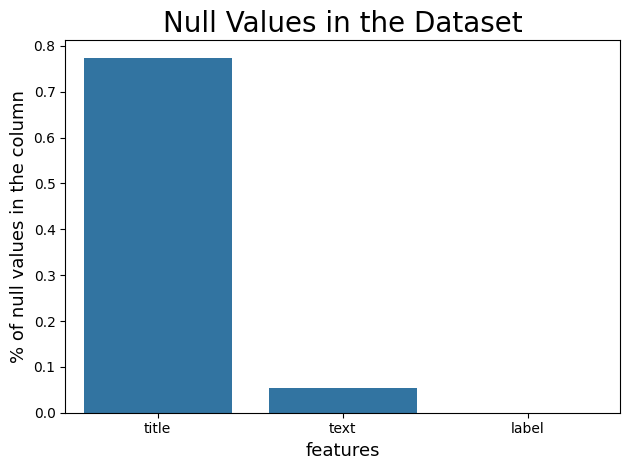

In [ ]:
def plot_nulls(data,title,x_axis_label,y_axis_label):

    # Number of nulls for each column
    data_nulls = (data.apply(lambda x:x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')

    sns.barplot(data_nulls,x="index",y="count")
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=13)
    plt.ylabel(y_axis_label,fontsize=13)

    plt.tight_layout()
    plt.show()

plot_nulls(data,"Null Values in the Dataset",'features','% of null values in the column')

In [ ]:
data.dropna(subset=["text"], inplace=True)

In [ ]:
data['title'].fillna('', inplace=True)

In [ ]:
data.isnull().sum()

,0
title,0
text,0
label,0


In [ ]:
data.shape

(72095, 3)

In [ ]:
data.isnull().sum()

,0
title,0
text,0
label,0


# Remove duplicate values

In [ ]:
data.duplicated().sum()

8456

In [ ]:
data.drop_duplicates(inplace=True,keep='first')

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
63634,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1
63635,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
63636,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
63637,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0


In [ ]:
data['final_text'] = data['title'] + ' ' + data['text']

In [ ]:
data

,title,text,label,final_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...
...,...,...,...,...
63634,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...
63635,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Russians steal research on Trump in hack of U....
63636,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,WATCH: Giuliani Demands That Democrats Apolog...
63637,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Migrants Refuse To Leave Train At Refugee Camp...


In [ ]:
data['final_text'][63635] #0


'Russians steal research on Trump in hack of U.S. Democratic Party WASHINGTON (Reuters) - Hackers believed to be working for the Russian government broke into the Democratic National Committee’s computer network, spied on internal communications and accessed research on presumptive Republican presidential nominee Donald Trump, the committee and security experts said on Tuesday. Two separate groups entered the DNC’s system, and one read email and chat communications for nearly a year before being detected, according to the committee and CrowdStrike, the cyber firm that helped clean up the breach. Russian spies also targeted the networks of Trump and Democratic presidential candidate Hillary Clinton, as well as the computers of some Republican political action committees, the Washington Post quoted U.S. officials as saying, although details were not available. A Clinton campaign official said there was no evidence the campaign’s information systems had been hacked. A Russian government s

In [ ]:
data['final_text'][3] #0

'Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled from Hinduism to Protestant Christianity and, ultimately, became what he calls an “evangelical Catholic.”\n\nOver two hours, Jindal, 42, recalled talking with a girl in high school who wanted to “save my soul,” reading the Bible in a closet so his parents would not see him and feeling a stir while watching a movie during his senior year that depicted Jesus on the cross.\n\n“I was struck, and struck hard,” Jindal told the pastors. “This was the Son of God, and He had died for our sins.”\n\nJindal’s session with the Christian clergy, who lead congregations in the early presidential battleground states of Iowa and South Carolina, was part of a behind-the-scenes effort by the Louisiana governo

In [ ]:
data['final_text'][4] #1

'SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec and with a range of 6,213 miles (10,000km) The weapons are perceived as part of an increasingly aggressive Russia It could deliver a warhead of 40 megatons – 2,000 times as powerful as the atom bombs dropped on Hiroshima and Nagasaki in 1945 By LIBBY PLUMMER and GARETH DAVIE S Russia has unveiled chilling pictures of its largest ever nuclear missile, capable of destroying an area the size of France. The RS-28 Sarmat missile, dubbed Satan 2 by Nato, has a top speed of 4.3 miles (7km) per second and has been designed to outfox anti-missile shield systems. The new Sarmat missile could deliver warheads of 40 megatons – 2,000 times as powerful as the atom bombs dropped on Hiroshima and Nagasaki in 1945. Scroll down for video Russian President Vladimir Putin is reportedly planning to replace the coun

In [ ]:
data['final_text'][63636] #1

' WATCH: Giuliani Demands That Democrats Apologize For Trump’s Racist Birtherism You know, because in fantasyland Republicans never questioned the citizenship of America s first black president.But that s exactly what they did for years and Donald Trump led the charge by going on or calling into Fox News every chance he could in order to demand President Obama s birth certificate.It was Trump who constantly claimed President Obama was born in Kenya even though Hawaii newspapers from the time announce Obama s birth.Trump and his birther fans were finally utterly humiliated when President Obama released his birth certificate to the public.And now that birtherism is coming back to bite Trump on the ass as he tries to convince black voters that he isn t a racist.Part of the reason why black voters reject Trump is because he questioned the citizenship of President Obama simply because he is black. But Trump wants everyone to pretend he didn t say any nasty things about President Obama and T

# Valeurs aberrantes

In [ ]:
data.shape

(63639, 4)

# EDA

In [ ]:
data['label'].value_counts()

,count
label,
0,34791
1,28848


In [ ]:
label_Status = data['label'].value_counts()
transactions = label_Status.index
quantity = label_Status.values

figure = px.pie(data,
             values=quantity,
             names=transactions, hole =.60,
             title="Fake & Real")
figure.show()

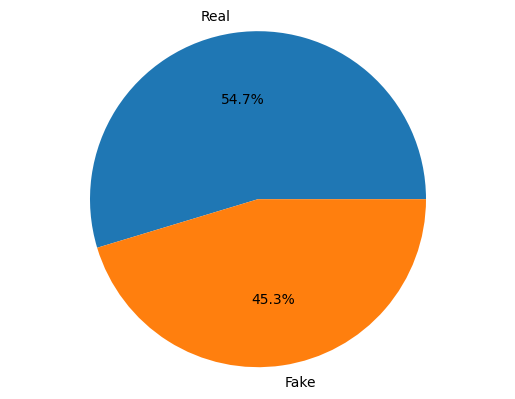

In [ ]:
plt.pie(data['label'].value_counts(), labels=['Real', 'Fake'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

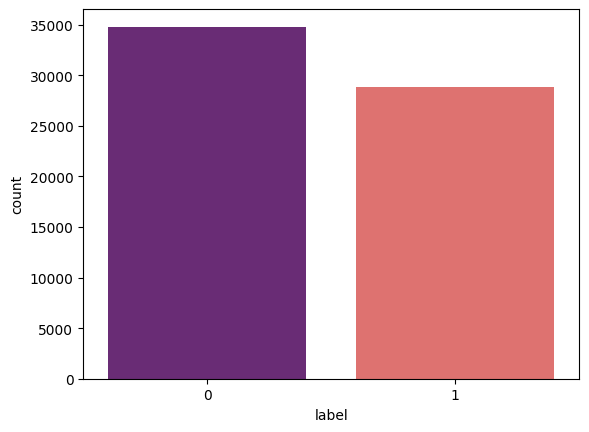

In [ ]:
sns.countplot(x = 'label', data = data,palette = 'magma')
plt.show()

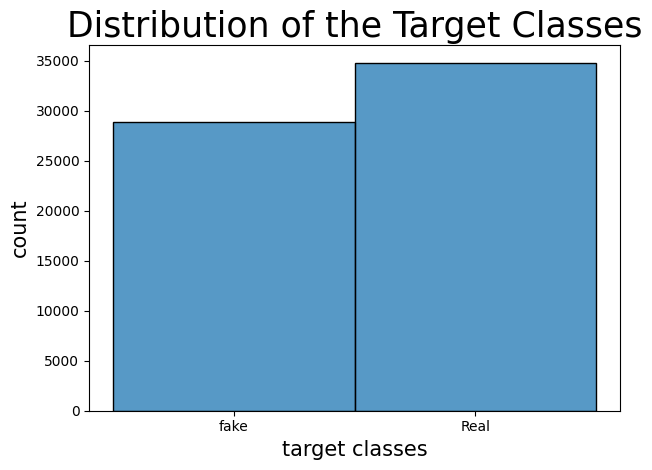

In [ ]:
# Creating a column with 'readable' labels for the news

news_map = {1:'fake',0:'Real'}
data['label_names'] = data['label'].map(news_map)

sns.histplot(data=data.label_names)
plt.title('Distribution of the Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

# Feauture

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
data.head()

,title,text,label,final_text,label_names
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,fake
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,fake
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,fake
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",Real
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,fake


In [ ]:
data.head()

,title,text,label,final_text,label_names
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,fake
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,fake
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,fake
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",Real
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,fake


In [ ]:
data.head()

,title,text,label,final_text,label_names
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,fake
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,fake
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,fake
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",Real
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,fake


In [ ]:
data['label_names']=data['label'].map({1:'fake',0:'real'})

In [ ]:
data['label_names']

,label_names
0,fake
1,fake
2,fake
3,real
4,fake
...,...
63634,fake
63635,real
63636,fake
63637,real


In [ ]:
data.head()

,title,text,label,final_text,label_names
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,fake
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,fake
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,fake
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",real
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,fake


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
data_fake = data[data['label']==1]
data_true = data[data['label']==0]

In [ ]:
data_fake.head()

,title,text,label,final_text,label_names
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,fake
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,fake
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,fake
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,fake
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...,fake


# Observation:

In [ ]:
# Shuffle the dataframe
data = data.sample(frac=1,random_state=42)

# Exploratory Data Analysis

1.   Élément de liste
2.   Élément de liste



In [ ]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Removing stop words which are unneccesary from headline news
def remove_stopwords(text):
    f_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            f_text.append(i.strip())
    return " ".join(f_text)

data['final_text']=data['final_text'].apply(remove_stopwords)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_fake.final_text))
#plt.imshow(wc , interpolation = 'bilinear')



<Figure size 2000x2000 with 0 Axes>

In [ ]:
plt.figure(figsize = (20,20)) # Text that is True News Headlines
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_true.final_text))
#plt.imshow(wc , interpolation = 'bilinear')

<Figure size 2000x2000 with 0 Axes>

# Step 4: Create word clouds

In [ ]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)

fake_text = ' '.join(data[data['label'] == 1]['text'])
real_text = ' '.join(data[data['label'] == 0]['text'])

In [ ]:
#plot_wordcloud(fake_text, 'Fake News')
#plt.show()

In [ ]:
#plot_wordcloud(real_text, 'Real News')
#plt.show()

# Step 5: Text preprocessing

# Removing Stopwords and punctuation

In [ ]:
text_column = 'final_text'
label_column = 'label'

In [ ]:
import nltk
import re
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
stopword



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
data['final_text'][62717]

'watch \'s key Clinton-Sanders debate New York New York (CNN) Hillary Clinton Bernie Sanders face CNN\'s Democratic presidential debate Brooklyn Thursday night spar ahead critical contest New York -- state candidates deep roots. April 19 primary come Clinton -- whose campaign dogged Sanders\' unexpected endurance -- urgent mission widen delegate lead lock party\'s nomination. Next week\'s contest serve one Sanders\' last opportunities change dynamics Democratic race. turn, offer Clinton crucial opening shake pervasive narrative rival -- even lags behind delegate count -- continues enjoy real momentum; tens thousands Sanders supporters rallied Washington Square Park Manhattan Wednesday night. sign mounting pressure candidates, past weeks, exchanges campaign trail grown increasingly bitter. Sanders publicly questioned Clinton\'s judgment credibility, Clinton hit back accusing rival inexperienced promoting unrealistic platform. Next week\'s contest also especially personal one Democratic 

In [ ]:
data['final_text'][4240]

'U.S. withdrawal Paris deal good sign aviation accord: IATA BERLIN (Reuters) decision U.S. President Donald Trump withdraw Paris climate agreement would send good signal separate deal agreed last year seeks curb aviation emissions, global airlines body IATA said Thursday. Aviation part Paris accord fight climate change industry last year agreed deal combat aviation pollution, also known Carbon Offset Reduction Scheme International Aviation (CORSIA). “Any decision withdraw Paris agreement U.S. sending good signal, even U.S. could remain CORSIA withdraw Paris agreement. it’s decided two completely separate,” IATA director general Alexandre de Juniac said Thursday.'

In [ ]:
# removing news source info from text
def extract_txt(text):
    regex = re.search(r"(?<=\(Reuters\)\s\-\s).*",text)
    if regex:
        return regex.group(0)
    return text


In [ ]:
data[text_column] = data[text_column].apply(extract_txt)

In [ ]:
data['final_text'][4240]

'U.S. withdrawal Paris deal good sign aviation accord: IATA BERLIN (Reuters) decision U.S. President Donald Trump withdraw Paris climate agreement would send good signal separate deal agreed last year seeks curb aviation emissions, global airlines body IATA said Thursday. Aviation part Paris accord fight climate change industry last year agreed deal combat aviation pollution, also known Carbon Offset Reduction Scheme International Aviation (CORSIA). “Any decision withdraw Paris agreement U.S. sending good signal, even U.S. could remain CORSIA withdraw Paris agreement. it’s decided two completely separate,” IATA director general Alexandre de Juniac said Thursday.'

In [ ]:
data[text_column].isnull().sum()

0

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from wordcloud import WordCloud

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sentence = re.sub('[^a-zA-Z0-9]', ' ', sentence)  # Suppression des caractères non alphanumériques sauf les nombres
        sentence = sentence.lower()
        words = nltk.word_tokenize(sentence)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        preprocessed_text.append(' '.join(words))
    return preprocessed_text

# Appliquer à la colonne 'text'



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data['final_text'] = preprocess_text(data['final_text'])

100%|██████████| 63639/63639 [03:30<00:00, 302.64it/s]


In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data

,title,text,label,final_text,label_names
0,Kenya bans city-center protests as vote tensio...,NAIROBI (Reuters) - Kenyan authorities banned ...,0,kenya ban city center protest vote tension mou...,real
1,The New Cold War: A Chilling Prospect for the ...,21st Century Wire says There is one curious th...,1,new cold war chilling prospect world 21st cent...,fake
2,"Blast at Tupras refinery in Turkey kills four,...",ISTANBUL (Reuters) - An explosion in a storage...,0,blast tupras refinery turkey kill four product...,real
3,Preet Bharara: ’There’s Absolutely Evidence to...,"Sunday on ABC’s “This Week,” former U. S. Atto...",0,preet bharara absolutely evidence begin case o...,real
4,MEGYN KELLY OFFENDED BY TRUMP BUT OKAY WITH SE...,Howard Stern: You seem to be pretty conservati...,1,megyn kelly offended trump okay sexist intervi...,fake
...,...,...,...,...,...
63634,86 YR OLD BARBARA WALTERS Tells 40 Yr Old ‘Ame...,"Real journalism ended a long time ago, but thi...",1,86 yr old barbara walter tell 40 yr old americ...,fake
63635,Trump says tax reform 'will be better' if Obam...,WASHINGTON (Reuters) - President Donald Trump ...,0,trump say tax reform better obamacare repeal p...,real
63636,High School Forced to Change Mascot over Accus...,A school district in Kentucky has canceled the...,0,high school forced change mascot accusation st...,real
63637,President Obama and India’s Modi Forge an Unli...,WASHINGTON — There are few relationships be...,0,president obama india modi forge unlikely frie...,real


In [ ]:
data[text_column][4]

'megyn kelly offended trump okay sexist interview shock jock howard stern weight boob sex audio howard stern seem pretty conservative kinda megyn conservative thing others love people make assumption work fox howard well make assumption hear question line question megyn job megyn seems selective talk woman weight appearance sure sound like problem talking stern appearance important good look physique job fact appears though megyn actually find line questioning quite amusing also spent considerable amount time talking sex life breast size husband penis nope nothing seems offend megyn interview http youtu iml ughxz2q'

# Lemmatization

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text])
    return lemmatized_text

In [ ]:
data[text_column]

,final_text
0,kenya ban city center protest vote tension mou...
1,new cold war chilling prospect world 21st cent...
2,blast tupras refinery turkey kill four product...
3,preet bharara absolutely evidence begin case o...
4,megyn kelly offended trump okay sexist intervi...
...,...
63634,86 yr old barbara walter tell 40 yr old americ...
63635,trump say tax reform better obamacare repeal p...
63636,high school forced change mascot accusation st...
63637,president obama india modi forge unlikely frie...


# Step 7: Split dataset into training and testing sets

In [ ]:
x=data[text_column]
y=data[label_column]

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
xtrain.shape,xtest.shape


((44547,), (19092,))

In [ ]:
xtrain.reset_index(drop=True, inplace=True)

In [ ]:
xtrain

,final_text
0,u say ban bomb nobel winner make world peacefu...
1,trump explodes smiling protester like punch fa...
2,
3,many chicago south side obama farewell persona...
4,somalia release jailed ex minister government ...
...,...
44542,putin issue international arrest warrant georg...
44543,venezuela government foe resume talk breakthro...
44544,intel report nunes ran trump reveal bombshell ...
44545,japanese pm abe sends ritual offering yasukuni...


In [ ]:
xtest.reset_index(drop=True, inplace=True)

In [ ]:
xtest

,final_text
0,word via ned dougherty nov 1 2016 wmw admin no...
1,white house deep denial dumpster fire healthca...
2,trump say u protective baltic region washingto...
3,eric holder condemn attorney general jeff sess...
4,former raider qb todd marinovich pleads guilty...
...,...
19087,glenn reynolds donald trump response bullying ...
19088,giuliani leading candidate trump secretary sta...
19089,trump jr latest move prof russia investigation...
19090,middle class egypt adapts survive austerity bi...


In [ ]:
ytest.reset_index(drop=True, inplace=True)

In [ ]:
ytest.reset_index(drop=True, inplace=True)

In [ ]:
xtest[18814]

'trump becomes ensnared fiery g p civil war new york time washington president trump ignites lot fight failure repeal affordable care act biggest defeat short time white house result something else republican civil war humbled generation party leader ever came washington president belief washington usual rule apply mr trump find shackled stopping repeal president barack obama proudest legacy republican party professed priority last seven year even coming vote rebellious far right wing mr trump taking defeating party establishment long war lead like every one else tried rule fissured fractious party mr trump face wrenching choice retrenchment realignment cede power wing party seek pathway successful governing throwing away partisan playbook courting coalition democrat improbably blamed party shortcoming really problem party something need deal moving forward said representative tom cole oklahoma ally tuesday group stuck mr trump health care fight earned president praise hour bill defeat

In [ ]:
ytest[18814]

0

In [ ]:
xtest[34]

'trump offer session attorney general post cbs news washington reuters president elect donald trump offered republican senator jeff session job u attorney general cbs news bloomberg reported friday republican national committee spokesman sean spicer involved trump presidential transition would confirm report cnn donald trump say official spicer said'

In [ ]:
ytest[34]

0

In [ ]:
xtest[18813]

'tank seen heading toward zimbabwe capital witness harare reuters four tank seen heading toward zimbabwe capital harare tuesday witness said day head armed force said prepared step end purge supporter ousted vice president emmerson mnangagwa reuters witness saw two tank parked beside main road harare chinhoyi 20 km 14 mile city one tank pointed direction capital come track soldier scene refused talk reuters version story refiled fix typo second paragraph'

In [ ]:
ytest[18813]

0

In [ ]:
xtest[4]

'former raider qb todd marinovich pleads guilty drug public nudity breitbart todd marinovich former quarterback usc trojan angeles raider pleaded guilty several misdemeanor charge tuesday marinovich 47 found naked residential backyard irvine california back august time police stated marinovich possession brown bag methamphetamine marijuana syrinx marijuana pipe wallet according orange county register marinovich plead guilty 5 misdemeanor count drug possession nudity trespassing also received 90 day jail sentence however marinovich avoid jail time successful completion 6 month rehab stint three year probationary period marinovich became high school legend california eventually made prized recruit usc strong start marinovich underwhelmed remaining time usc also arrest cocaine possession 1991 marinovich decided enter nfl draft became 24th overall selection raider yet played eight career game career flamed due drug issue follow dylan gwinn twitter themightygwinn'

In [ ]:
ytest[4]

0

# Step 7: TF-IDF Vectorization

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000,max_df=0.8,min_df=5,  ngram_range=(1, 2))



In [ ]:
xvtrain= vectorizer.fit_transform(xtrain)
xvtest = vectorizer.transform(xtest)

In [ ]:
xvtrain.shape,xvtest.shape

((44547, 10000), (19092, 10000))

In [ ]:
xvtrain.shape

(44547, 10000)

In [ ]:
import pickle

# Define a file path where you want to save the model
vectorizer_file = '/content/drive/MyDrive/dataset/tfidf_vectoriser.pkl'


In [ ]:
with open("vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

In [ ]:
xtrain[43898]

'reporter would run buzzfeed story trump russia rosie gray reporter work atlantic magazine told breitbart news exclusively disagrees decision old editor buzzfeed ben smith made run fake news dossier president donald trump accusing untoward relation russia would made decision run gray told breitbart news tuesday asked would run either buzzfeed story containing dossier previous cnn piece live television online aimed lend credibility dossier without actually publishing gray still consider smith mentor friend however gray decision speak publicly former employer buzzfeed noteworthy considering one top newsroom employee also new capacity reporter atlantic delivered one earliest strongest hammer blow smith cnn decision publish dossier discrediting buzzfeed cnn fake news meant malign mr trump read headline gray expo debunking buzzfeed report supposed intelligence document alleging number salacious thing trump team michael cohen attorney denied allegation contained dossier published buzzfeed ne

In [ ]:
x=xvtrain[43898].toarray()

In [ ]:
x.tolist()

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.011390743361562526,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.01992342878762869,
  0.0,
  0.0,
  0.0,
  0.0,
  0.11679942727614653,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.124505880

# Step 09: Evaluate Naive Bayes models

In [ ]:
def evaluate_model(model, xtest, ytest):
    y_pred = model.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    cm = confusion_matrix(ytest, y_pred)
    prob = model.predict_proba(xtest)[:, 1]
    roc_auc = roc_auc_score(ytest, prob)
    fpr, tpr, thresholds = roc_curve(ytest, prob)
    precision, recall, _ = precision_recall_curve(ytest, prob)
    pr_auc = auc(recall, precision)

    return {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
    }

# GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from xgboost import XGBClassifier

# Liste des modèles et de leurs hyperparamètres
models_and_params = {
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "max_iter": [200, 500,1000],
            "solver": ["liblinear", "lbfgs"]
        }
    },

    "DecisionTree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 10, 20, 30],
            "criterion": ["gini", "entropy"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
            "criterion": ["gini", "entropy"]
        }
    },
    "BernoulliNB": {
        "model": BernoulliNB(),
        "params": {
            "alpha": [0.1, 0.5, 1.0]
        }
    },
    "MultinomialNB": {
        "model": MultinomialNB(),
        "params": {
            "alpha": [0.1, 0.5, 1.0]
        }
    },
    "XGBClassifier": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2]
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10, 100],
            "kernel": ["linear", "rbf", "poly"]
        }
    }
}



# Step 10: Build Naive Bayes models

# Multinomial Naive Bayes

In [ ]:
mnb_model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
mnb_model.fit(xvtrain, ytrain)
mnb_pred=mnb_model.predict(xvtest)

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay

In [ ]:
# Évaluation du modèle
print('Accuracy  on training set: {:.2f}'.format(mnb_model.score(xvtrain, ytrain)))
print('Accuracy on test set: {:.2f}'.format(mnb_model.score(xvtest, ytest)))

Accuracy  on training set: 0.87
Accuracy on test set: 0.86


In [ ]:
nb_results = evaluate_model(mnb_model, xvtest, ytest)
nb_results

{'Accuracy': 0.8574795725958516,
 'Confusion Matrix': array([[8934, 1560],
        [1161, 7437]])}

# Evaluate Manually

In [ ]:
cm = confusion_matrix(ytest, mnb_pred)
cm

array([[8934, 1560],
       [1161, 7437]])

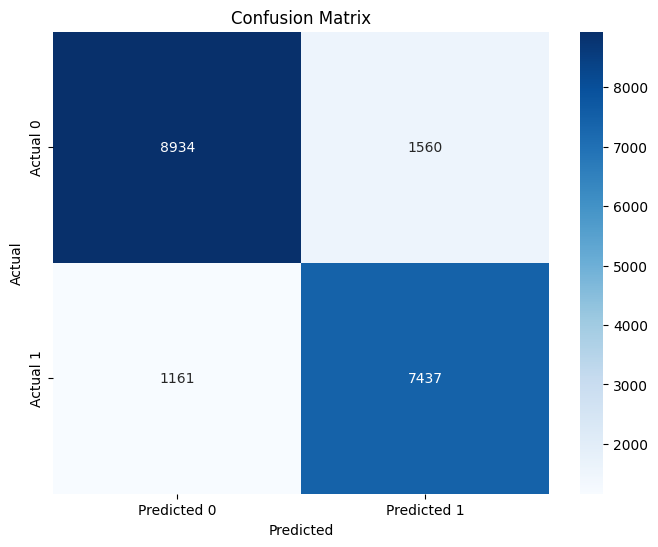

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(ytest, mnb_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     10494
           1       0.83      0.86      0.85      8598

    accuracy                           0.86     19092
   macro avg       0.86      0.86      0.86     19092
weighted avg       0.86      0.86      0.86     19092



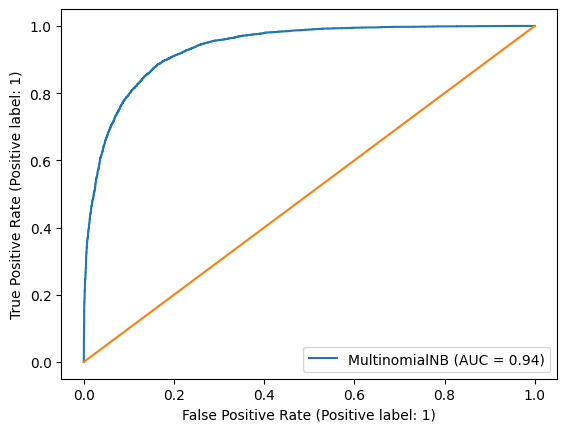

In [ ]:
mnb_disp = RocCurveDisplay.from_estimator(mnb_model, xvtest, ytest)
plt.plot([0,1],[0,1])
plt.show()

# Bernoulli Naive Bayes

In [ ]:
bnb_model = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
bnb_model.fit(xvtrain, ytrain)
bnb_pred=bnb_model.predict(xvtest)

In [ ]:
# Évaluation du modèle
print('Accuracy  on training set: {:.2f}'.format(bnb_model.score(xvtrain, ytrain)))
print('Accuracy on test set: {:.2f}'.format(bnb_model.score(xvtest, ytest)))

Accuracy  on training set: 0.85
Accuracy on test set: 0.84


In [ ]:
bnb_results = evaluate_model(bnb_model, xvtest, ytest)
bnb_results


{'Accuracy': 0.8395139325371883,
 'Confusion Matrix': array([[8365, 2129],
        [ 935, 7663]])}

In [ ]:
cm_bnb = confusion_matrix(ytest, bnb_pred)
cm_bnb

array([[8365, 2129],
       [ 935, 7663]])

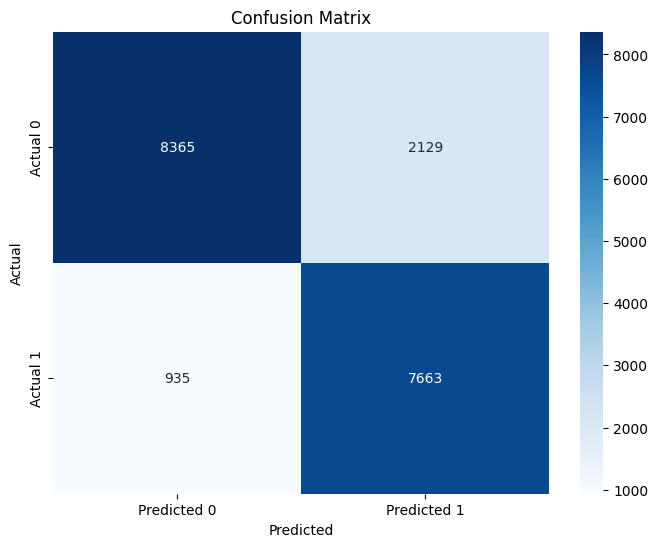

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bnb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(ytest, bnb_pred))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85     10494
           1       0.78      0.89      0.83      8598

    accuracy                           0.84     19092
   macro avg       0.84      0.84      0.84     19092
weighted avg       0.85      0.84      0.84     19092



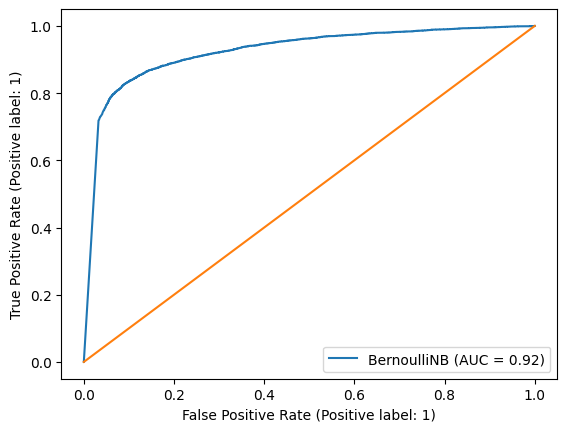

In [ ]:
bnb_disp = RocCurveDisplay.from_estimator(bnb_model, xvtest, ytest)
plt.plot([0,1],[0,1])
plt.show()

# Step 11: Apply Logistic Regression

In [ ]:
lr_model = LogisticRegression(C=10,solver='liblinear',max_iter=1000)
lr_model.fit(xvtrain, ytrain)
lr_pred=lr_model.predict(xvtest)


In [ ]:
# Évaluation du modèle
print('Accuracy  on training set: {:.2f}'.format(lr_model.score(xvtrain, ytrain)))
print('Accuracy on test set: {:.2f}'.format(lr_model.score(xvtest, ytest)))

Accuracy  on training set: 0.99
Accuracy on test set: 0.96


In [ ]:
lr_results = evaluate_model(lr_model, xvtest, ytest)
lr_results

{'Accuracy': 0.9576262308820448,
 'Confusion Matrix': array([[10106,   388],
        [  421,  8177]])}

In [ ]:
cm_lr = confusion_matrix(ytest, lr_pred)
cm_lr

array([[10106,   388],
       [  421,  8177]])

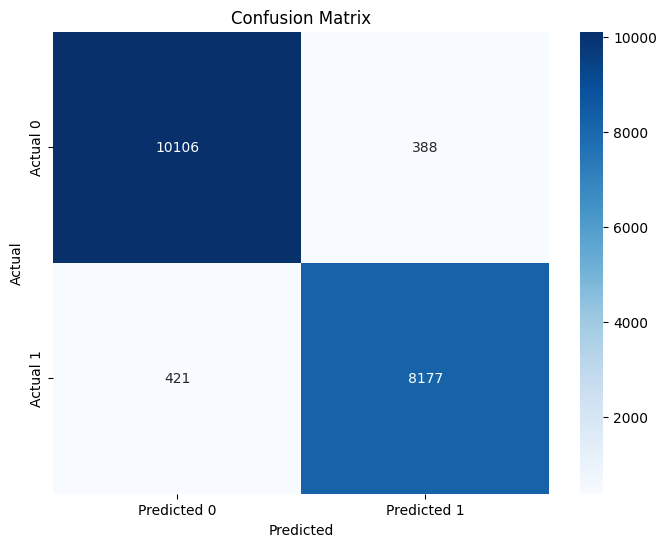

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(ytest, lr_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10494
           1       0.95      0.95      0.95      8598

    accuracy                           0.96     19092
   macro avg       0.96      0.96      0.96     19092
weighted avg       0.96      0.96      0.96     19092



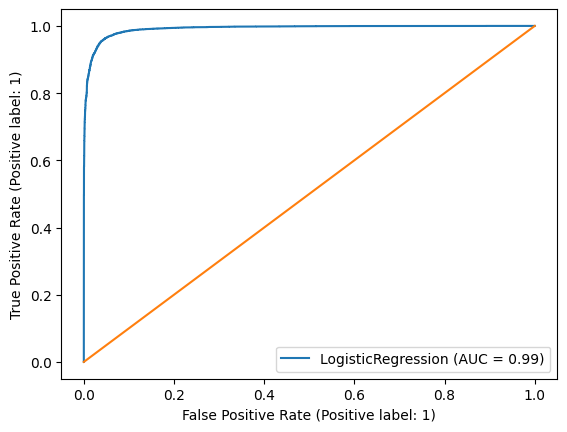

In [ ]:
lr_disp = RocCurveDisplay.from_estimator(lr_model, xvtest, ytest)
plt.plot([0,1],[0,1])
plt.show()

# SVM

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(xvtrain, ytrain)


In [ ]:
svm_pred=svm_model.predict(xvtest)

In [ ]:
# Évaluation du modèle
print('Accuracy  on training set: {:.2f}'.format(svm_model.score(xvtrain, ytrain)))
print('Accuracy on test set: {:.2f}'.format(svm_model.score(xvtest, ytest)))

Accuracy  on training set: 0.98
Accuracy on test set: 0.96


In [ ]:
accuracy_svm=accuracy_score(svm_pred,ytest)
print(accuracy_svm)

0.9566834276136602


In [ ]:
cm_svm = confusion_matrix(ytest, svm_pred)
cm_svm

array([[10095,   399],
       [  428,  8170]])

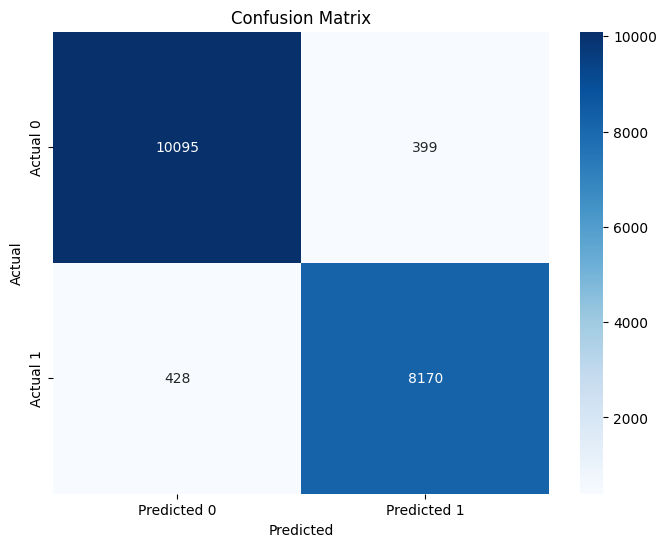

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(ytest, svm_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10494
           1       0.95      0.95      0.95      8598

    accuracy                           0.96     19092
   macro avg       0.96      0.96      0.96     19092
weighted avg       0.96      0.96      0.96     19092



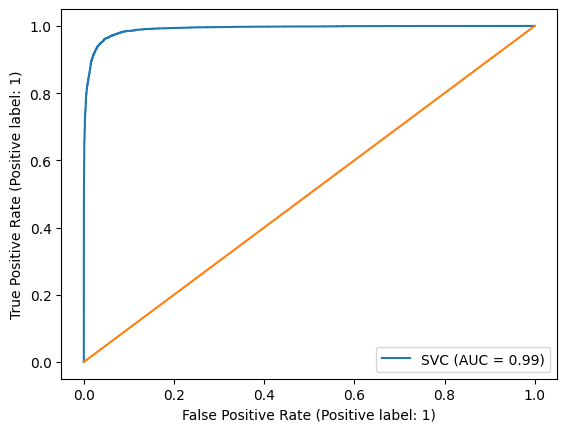

In [ ]:
svm_disp = RocCurveDisplay.from_estimator(svm_model, xvtest, ytest)
plt.plot([0,1],[0,1])
plt.show()

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(criterion= 'gini', max_depth= 10)
dt.fit(xvtrain, ytrain)


NameError: name 'xvtrain' is not defined

In [ ]:
dt_pred = dt.predict(xvtest)

In [ ]:
# Évaluation du modèle
print('Accuracy  on training set: {:.2f}'.format(dt.score(xvtrain, ytrain)))
print('Accuracy on test set: {:.2f}'.format(dt.score(xvtest, ytest)))

Accuracy  on training set: 0.94
Accuracy on test set: 0.93


In [ ]:
dt_results = evaluate_model(dt, xvtest, ytest)
dt_results

{'Accuracy': 0.9304944479363084,
 'Confusion Matrix': array([[9707,  787],
        [ 540, 8058]])}

In [ ]:
cm_dt = confusion_matrix(ytest, dt_pred)
cm_dt

array([[9707,  787],
       [ 540, 8058]])

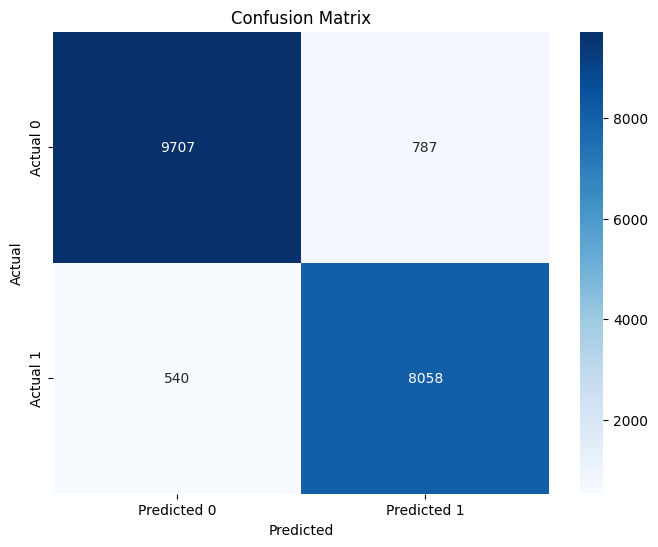

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
xvtest.shape

(19092, 10000)

In [ ]:
print(classification_report(ytest, dt_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     10494
           1       0.91      0.94      0.92      8598

    accuracy                           0.93     19092
   macro avg       0.93      0.93      0.93     19092
weighted avg       0.93      0.93      0.93     19092



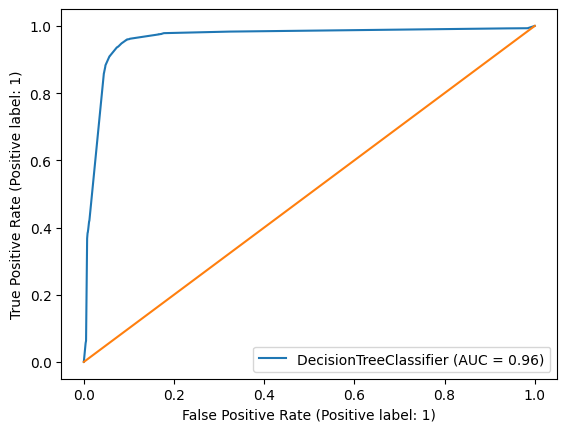

In [ ]:
dt_disp = RocCurveDisplay.from_estimator(dt, xvtest, ytest)
plt.plot([0,1],[0,1])
plt.show()

In [ ]:
importances=dt.feature_importances_

In [ ]:
print(importances*100)

[0. 0. 0. ... 0. 0. 0.]


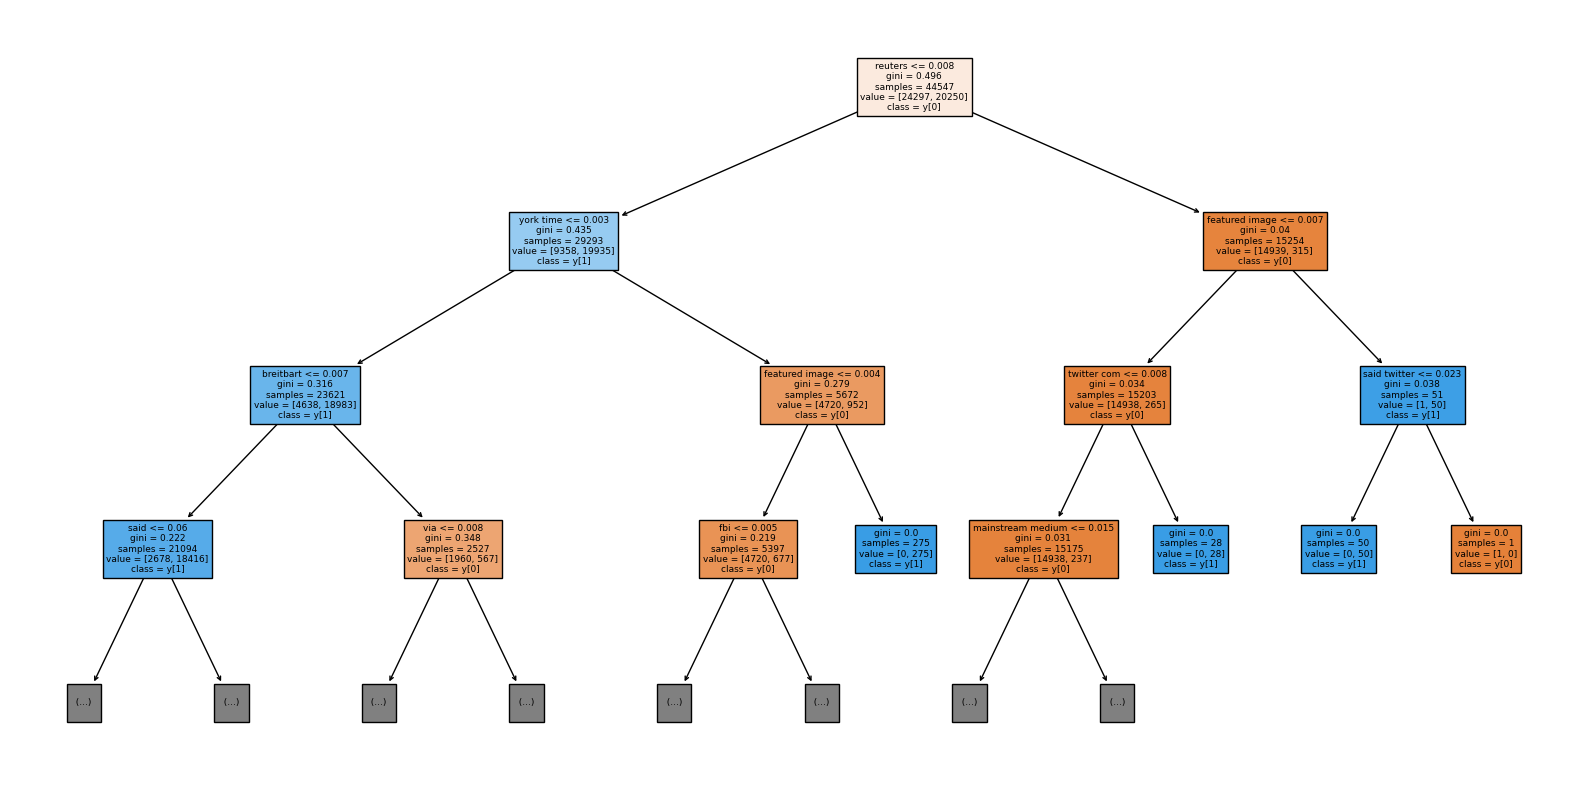

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Afficher l'arbre
plt.figure(figsize=(20, 10))  # Ajuster la taille de l'image
plot_tree(dt, feature_names=vectorizer.get_feature_names_out(), class_names=True, filled=True,max_depth=3)
plt.show()


In [ ]:
from sklearn.tree import export_graphviz
from sklearn import tree
import pydotplus
from IPython.display import Image
import graphviz
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=True,
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
plt.savefig("decision_tree.png", dpi=300, bbox_inches="tight")

graph.view()  # Afficher l'arbre dans une visionneuse

'Source.gv.pdf'

<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import files
files.download("decision_tree.png")


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=500)
rf.fit(xvtrain, ytrain)

RandomForestClassifier(n_estimators=500)

In [ ]:
rf_pred = rf.predict(xvtest)

In [ ]:
# Évaluation du modèle
print('Accuracy  on training set: {:.2f}'.format(rf.score(xvtrain, ytrain)))
print('Accuracy on test set: {:.2f}'.format(rf.score(xvtest, ytest)))

Accuracy  on training set: 1.00
Accuracy on test set: 0.95


In [ ]:
rf_results = evaluate_model(rf, xvtest, ytest)
rf_results

{'Accuracy': 0.949298135344647,
 'Confusion Matrix': array([[10103,   391],
        [  577,  8021]])}

In [ ]:
print(classification_report(ytest, rf_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10494
           1       0.95      0.93      0.94      8598

    accuracy                           0.95     19092
   macro avg       0.95      0.95      0.95     19092
weighted avg       0.95      0.95      0.95     19092



In [ ]:
cm_rf = confusion_matrix(ytest, rf_pred)
cm_rf

array([[10109,   385],
       [  591,  8007]])

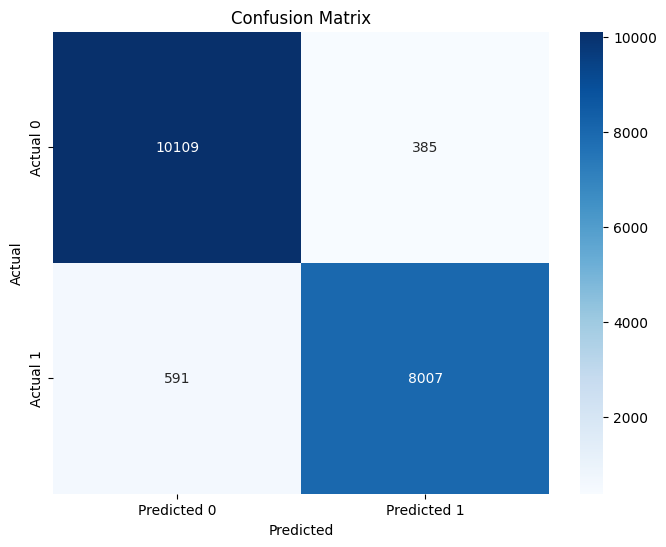

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

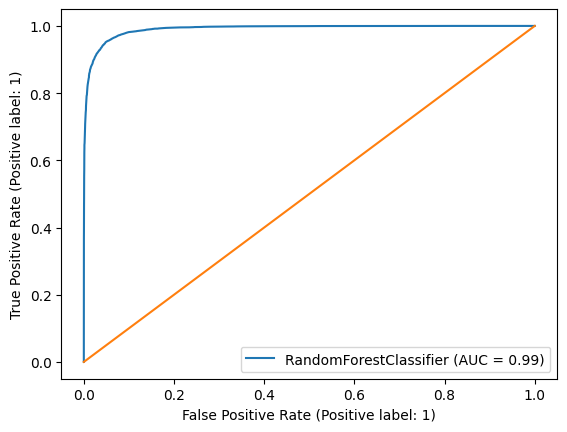

In [ ]:
rf_disp = RocCurveDisplay.from_estimator(rf, xvtest, ytest)
plt.plot([0,1],[0,1])
plt.show()

# XGBClassifier

In [ ]:
from xgboost import XGBClassifier
xgb=XGBClassifier(learning_rate=0.1, n_estimators=500)
xgb.fit(xvtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_results = evaluate_model(xgb, xvtest, ytest)
xgb_results

{'Accuracy': 0.9701445631678189,
 'Confusion Matrix': array([[10174,   320],
        [  250,  8348]])}

In [ ]:
# Évaluation du modèle
print('Accuracy  on training set: {:.2f}'.format(xgb.score(xvtrain, ytrain)))
print('Accuracy on test set: {:.2f}'.format(xgb.score(xvtest, ytest)))

Accuracy  on training set: 1.00
Accuracy on test set: 0.97


In [ ]:
xgb_pred=xgb.predict(xvtest)

In [ ]:
cm_xgb = confusion_matrix(ytest, xgb_pred)
cm_xgb

array([[10174,   320],
       [  250,  8348]])

In [ ]:
print(classification_report(ytest, xgb_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     10494
           1       0.96      0.97      0.97      8598

    accuracy                           0.97     19092
   macro avg       0.97      0.97      0.97     19092
weighted avg       0.97      0.97      0.97     19092



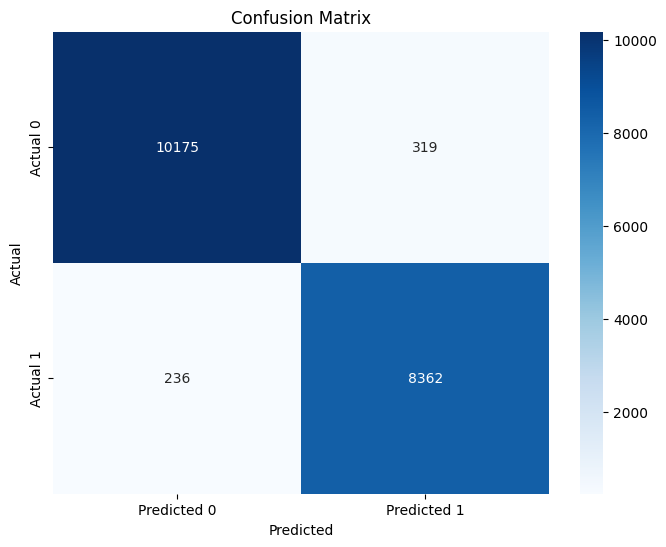

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

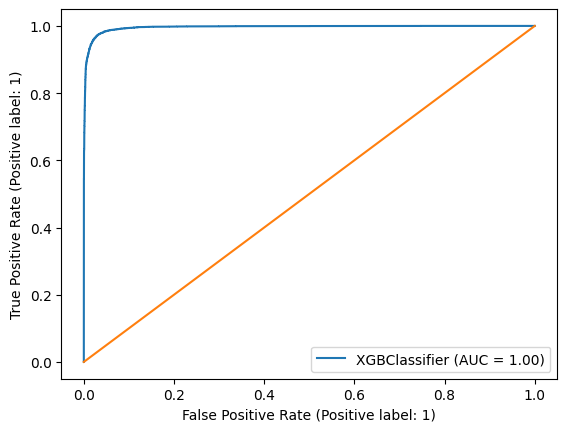

In [ ]:
dt_disp = RocCurveDisplay.from_estimator(xgb, xvtest, ytest)
plt.plot([0,1],[0,1])
plt.show()

# Comparaison Resulats

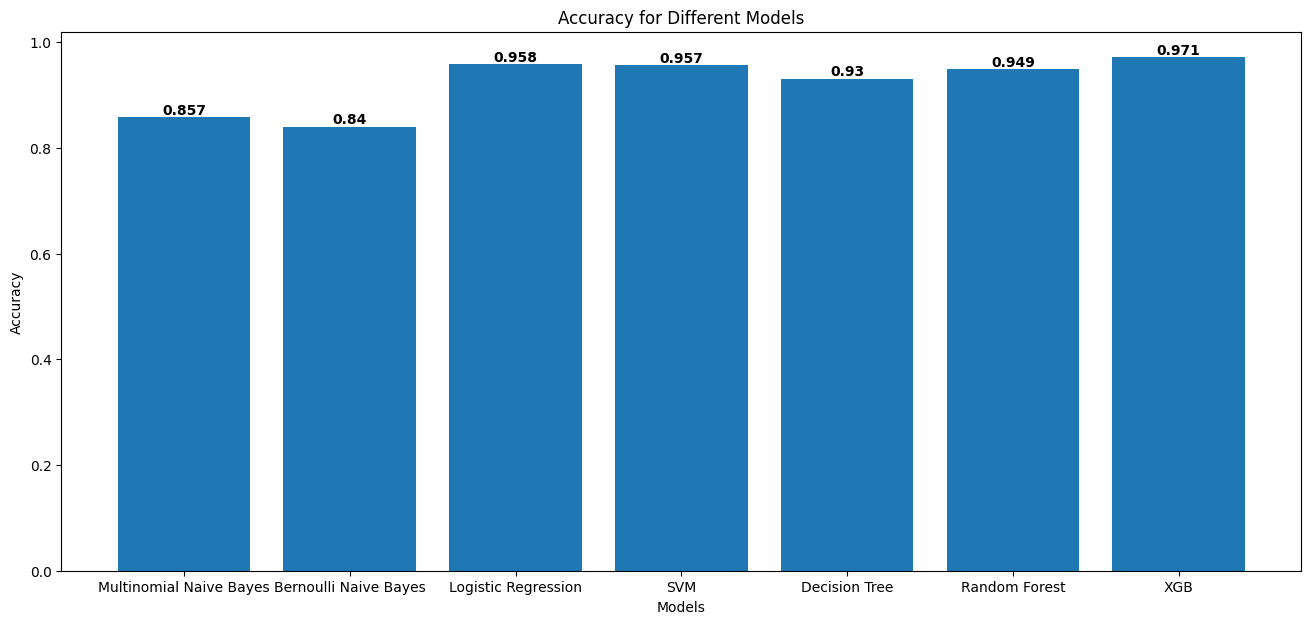

In [ ]:
def plot_histogram(metric_values, model_names, metric_name):
    fig, ax = plt.subplots(figsize=(16, 7))
    bars = plt.bar(model_names, metric_values)
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Models')

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')

    plt.show()

accuracy_values = [nb_results['Accuracy'], bnb_results['Accuracy'], lr_results['Accuracy'],accuracy_svm, dt_results['Accuracy'], rf_results['Accuracy'], xgb_results['Accuracy']]
model_names = ['Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'Logistic Regression','SVM' ,'Decision Tree','Random Forest','XGB']
plot_histogram(accuracy_values, model_names, 'Accuracy')

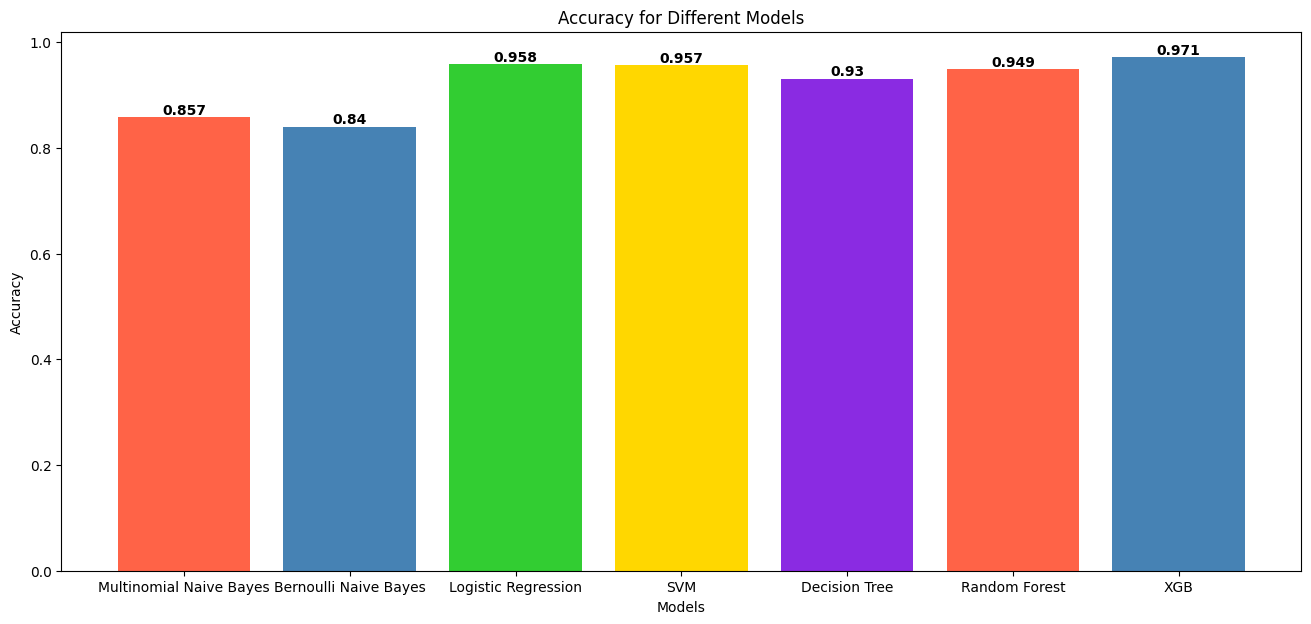

In [ ]:

def plot_histogram(metric_values, model_names, metric_name):
    # Définir les couleurs pour chaque barre
    colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2']  # Vous pouvez personnaliser les couleurs ici

    fig, ax = plt.subplots(figsize=(16, 7))
    bars = plt.bar(model_names, metric_values, color=colors)  # Ajouter les couleurs aux barres
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Models')

    # Ajouter les valeurs sur chaque barre
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')

    plt.show()

# Exemple d'appel avec les données :
accuracy_values = [nb_results['Accuracy'], bnb_results['Accuracy'], lr_results['Accuracy'],accuracy_svm, dt_results['Accuracy'], rf_results['Accuracy'], xgb_results['Accuracy']]
model_names = ['Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'Logistic Regression', 'SVM','Decision Tree','Random Forest','XGB']
plot_histogram(accuracy_values, model_names, 'Accuracy')


# Step 14: prediction

In [ ]:
models = [mnb_model, bnb_model, lr_model,svm_model,dt,rf,xgb]

In [ ]:
random_text = input()


trump is dead


In [ ]:
preprocessed_text = preprocess_text([random_text]) # remove punctuation


100%|██████████| 1/1 [00:00<00:00, 1924.88it/s]


In [ ]:
preprocessed_text

In [ ]:
text_vector = vectorizer.transform(preprocessed_text)

In [ ]:
text_vector

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [ ]:
text_vector.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
for model in models:
    prediction = model.predict(text_vector)
    print(f"Model: {type(model).__name__}")
    if prediction[0] == 0:
        print("Prediction: Real ")
    else:
        print("Prediction: Fake")
    print('\n')


Model: MultinomialNB
Prediction: Real 


Model: BernoulliNB
Prediction: Fake


Model: LogisticRegression
Prediction: Fake


Model: SVC
Prediction: Fake


Model: DecisionTreeClassifier
Prediction: Fake


Model: RandomForestClassifier
Prediction: Fake


Model: XGBClassifier
Prediction: Fake




# Step 16: Save Good ML Model for Deployment

In [ ]:
import pickle

# Define a file path where you want to save the model
model_file_path = '/content/drive/MyDrive/datasets/xgboosting_classifier_model.pkl'



In [ ]:
# Save the model to the file
with open(model_file_path, 'wb') as model_file:
    pickle.dump(xgb, model_file)

# Load Model

In [ ]:
with open(model_file_path, 'rb') as model_file:
    loaded_dt = pickle.load(model_file)

In [ ]:
loaded_dt.predict(xvtest)

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
loaded_dt.score(xvtest, ytest)

0.9709302325581395

In [ ]:
text_vector

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [ ]:
loaded_dt.predict(text_vector)

array([1])